# Tutorial for simulating spatial transcriptomics data with SpatialCorr-sim

We will demonstrate how to simulate spatial transcriptomics data with spatially varying correlation structure between pairs of genes and sets of genes.

## Import dependencies

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from anndata import AnnData
import importlib
import sys
from statsmodels.stats.multitest import multipletests, fdrcorrection
import json
import nest_asyncio

sys.path.append('..')

#from simulatecorr_sim import normalize_deviance_residuals as ndr
import spatialcorr_sim
from spatialcorr_sim import normalize_deviance_residuals as ndr
import spatialcorr
#from simulate_spatial import plot_spatial as ps

from collections import defaultdict

nest_asyncio.apply()

## Download a breast cancer dataset from 10x genomics

We're going to use this dataset as a "scaffold" from which to simulate data with known, spatially varying correlation

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Download data
adata = sc.datasets.visium_sge(sample_id="V1_Breast_Cancer_Block_A_Section_1")
adata.X = np.array(adata.X.todense())
adata.X = adata.X.astype(np.int32)

# Filter spots
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Let's take a  look at the image of the slide

... storing 'feature_types' as categorical
... storing 'genome' as categorical


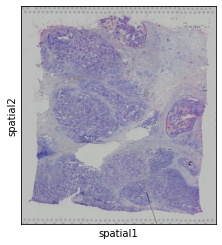

In [4]:
sc.pl.spatial(adata, alpha=0.0)

In [5]:
adata.raw = adata

In [6]:
total_counts = np.sum(adata.raw.X, axis=1)
total_counts.shape

(2759,)

In [7]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.15)

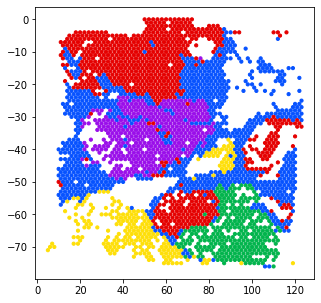

In [8]:
spatialcorr.plot.plot_slide(
    adata.obs,
    adata.obs['leiden'],
    cmap='categorical',
    row_key='array_row',
    col_key='array_col',
    dsize=10
)

## Rank genes by expression

In [9]:
adata_cts = adata.raw.to_adata()
n_spots_umi_gt_1 = np.sum((adata_cts.X > 0).astype(int), axis=0)
frac_spots_umi_gt_1 = np.sum((adata_cts.X > 0).astype(int), axis=0) / adata_cts.X.shape[0]
mean_umis = np.mean(adata_cts.X, axis=0)
median_umis = np.median(adata_cts.X, axis=0)
gene_stats_df = pd.DataFrame(
    data={
        'Mean UMI count': mean_umis,
        'Median UMI count': median_umis,
        'Number of spots w/ >1 UMI': n_spots_umi_gt_1,
        'Fraction of spots w/ >1 UMI':frac_spots_umi_gt_1
    },
    index=adata_cts.var.index
)
gene_stats_df

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,Mean UMI count,Median UMI count,Number of spots w/ >1 UMI,Fraction of spots w/ >1 UMI
MIR1302-2HG,0.000000,0.0,0,0.000000
FAM138A,0.000000,0.0,0,0.000000
OR4F5,0.000000,0.0,0,0.000000
AL627309.1,0.026459,0.0,71,0.025734
AL627309.3,0.000000,0.0,0,0.000000
...,...,...,...,...
AC141272.1,0.000000,0.0,0,0.000000
AC023491.2,0.000000,0.0,0,0.000000
AC007325.1,0.000000,0.0,0,0.000000
AC007325.4,0.279449,0.0,650,0.235593


Let's plot the first 600 genes' median UMI count ranked from high to low 

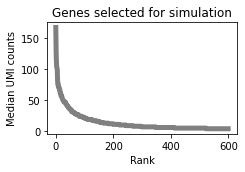

In [10]:
gene_stats_df_sort = gene_stats_df.sort_values('Median UMI count', axis=0, ascending=False)

fig, ax = plt.subplots(
    1,
    1,
    figsize = (3.5,2.5)
)
plt.plot(
    np.arange(0,600),
    gene_stats_df_sort.iloc[:600]['Median UMI count'],
    color='grey',
    lw=5
)

plt.title('Genes selected for simulation')
plt.xlabel('Rank')
plt.ylabel('Median UMI counts')

plt.tight_layout()

plt.show()

Let's grab the top ranked gene. We see that it is COX6C

In [11]:
RANK = 0 

gene_stats_df.sort_values('Median UMI count', axis=0, ascending=False).iloc[RANK]

Mean UMI count                  254.025009
Median UMI count                167.000000
Number of spots w/ >1 UMI      2759.000000
Fraction of spots w/ >1 UMI       1.000000
Name: COX6C, dtype: float64

Let's generate a dataset of spatially varying correlation using this top-ranked gene to parameterize the simulation model.  Specifically, our simulated dataset will consist of two genes where each gene's marginal distribution will be similar to this gene's UMI count distribution in the real data.

Note, we will generate a pattern of spatially varying correlation where the correlation between these two genes varies spatially within each region.

In [30]:
%%capture

sim_corrs, sim_covs, sim_adata = spatialcorr_sim.simulate_gene_pair_within_region_varying_correlation(
    adata.raw.to_adata(),        # The UMI counts data
    'COX6C',                     # The first gene to base the simulation on
    'COX6C',                     # The second gene to base the simulation on
    clust_key='leiden',          # The column in `adata.obs` that stores the region identifiers
    fisher_corr_mean=0,          # The mean correlation at each spot. The mean will be zero.
    bandwidth=10,                # Sets the coarseness of the varying correlation pattern.
    cov_strength=0.5,            # Sets how much the correlation varies across the slide.
    row_key='array_row',         # The column in `adata.obs` that stores each spot's row coordinate
    col_key='array_col',         # The column in `adata.obs` that stores each spot's row coordinate
    poisson=True,                # Generate UMI counts using the Poisson-lognormal model
    size_factors=np.full((2, len(total_counts)), total_counts).T    # The size factors to use at each spot
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Compare marginal distributions of UMI counts

Let's plot the marginal distribution of the UMI counts in the real data versus the simulated data. We see they match up pretty well.

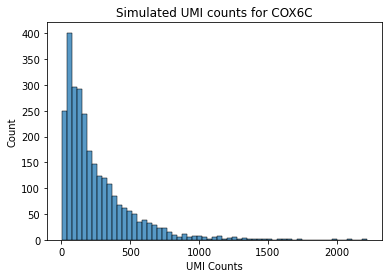

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


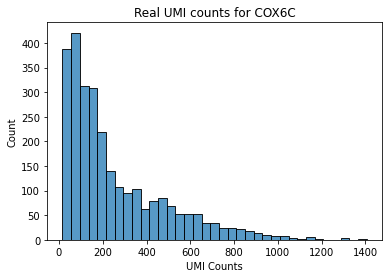

In [23]:
sns.histplot(sim_adata.X.T[0])
plt.title('Simulated UMI counts for COX6C')
plt.xlabel('UMI Counts')
plt.show()

sns.histplot(adata.raw.to_adata().obs_vector('COX6C'))
plt.title('Real UMI counts for COX6C')
plt.xlabel('UMI Counts')
plt.show()

## Plot latent correlation versus observed correlation

Now let's compare the latent correlation at each spot used by the model to generate the data to the observed correlation of the normalized UMI counts as estimated via Gaussian kernel estimation. Again, we see that they match well, though the estimated correlation in the simulated data tends to be weaker than the latent correlation used in the model. This is to be expected, as the simulation adds Poisson noise the to the latent lognormal-distributed expression values. We note that this discrepancy will increase as the expression decreases.

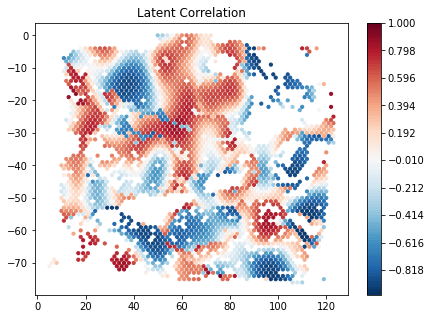

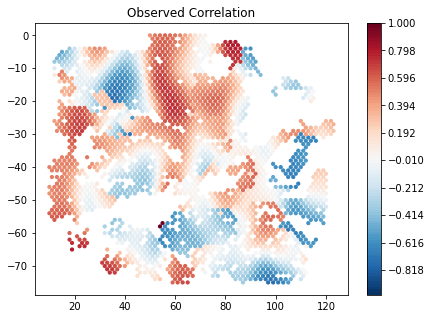

In [24]:
X_sim_norm = ndr.normalize(sim_adata.X, umi_counts=sim_adata.obs['n_counts'])

spatialcorr.plot.plot_slide(
    adata.obs,
    sim_corrs,
    vmin=-1,
    vmax=1,
    cmap='RdBu_r',
    colorbar=True,
    row_key='array_row',
    col_key='array_col',
    title='Latent Correlation',
    dsize=10
)

adata_sim_norm = AnnData(
    X=X_sim_norm,
    obs=sim_adata.obs,
    var=sim_adata.var
)
spatialcorr.plot.plot_correlation(
    adata_sim_norm, 
    '0', 
    '1',
    condition='leiden',
    title='Observed Correlation',
    row_key='array_row', 
    col_key='array_col'
); 

## Exploration of parameters

### Effect of "covariance strength" parameter

The "covariance strength" parameter increases the variability (and therefore strength) of correlation across the slide. Higher values for this parameter will produce more spots with correlations near -1 and 1. Small values will produce more spots with correlation near zero.

In [17]:
%%capture

cov_strengths = [0.025, 0.2, 0.4]
sim_corrs_all = []

for cov_strength in cov_strengths:
    sim_corrs, sim_covs, sim_adata = spatialcorr_sim.simulate_gene_pair_within_region_varying_correlation(
        adata.raw.to_adata(),        # The UMI counts data
        'COX6C',                     # The first gene to base the simulation on
        'COX6C',                     # The second gene to base the simulation on
        clust_key='leiden',          # The column in `adata.obs` that stores the region identifiers
        fisher_corr_mean=0,          # The mean correlation at each spot. The mean will be zero.
        bandwidth=10,                # Sets the coarseness of the varying correlation pattern.
        cov_strength=cov_strength,   # Sets how much the correlation varies across the slide.
        row_key='array_row',         # The column in `adata.obs` that stores each spot's row coordinate
        col_key='array_col',         # The column in `adata.obs` that stores each spot's row coordinate
        poisson=True,                # Generate UMI counts using the Poisson-lognormal model
        size_factors=np.full((2, len(total_counts)), total_counts).T    # The size factors to use at each spot
    )
    sim_corrs_all.append(sim_corrs)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


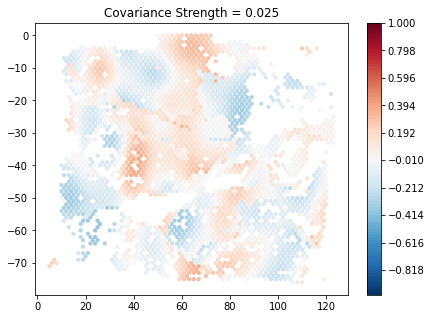

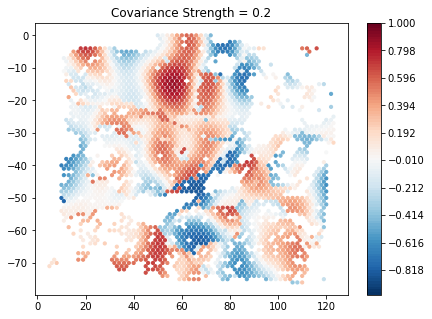

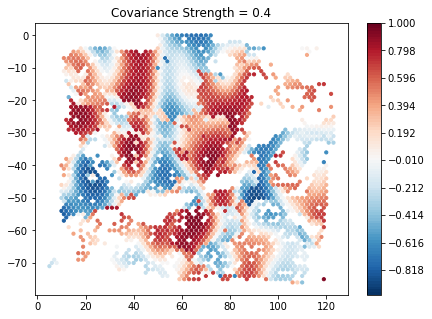

In [18]:
for sim_corrs, cov_strength in zip(sim_corrs_all, cov_strengths):
    spatialcorr.plot.plot_slide(
        adata.obs,
        sim_corrs,
        vmin=-1,
        vmax=1,
        cmap='RdBu_r',
        colorbar=True,
        row_key='array_row',
        col_key='array_col',
        title=f'Covariance Strength = {cov_strength}',
        dsize=10
    )
    plt.show()

### Effect of the bandwidth parameter

The bandwidth parameter controls the coarseness of the spatially varying correlation patterns. Larger values will create larger regions with similar correlation. Smaller values create smaller regions with similar correlation as seen below:

In [20]:
%%capture

bandwidths = [5, 10, 15]
sim_corrs_all = []

for bandwidth in bandwidths:
    sim_corrs, sim_covs, sim_adata = spatialcorr_sim.simulate_gene_pair_within_region_varying_correlation(
        adata.raw.to_adata(),        # The UMI counts data
        'COX6C',                     # The first gene to base the simulation on
        'COX6C',                     # The second gene to base the simulation on
        clust_key='leiden',          # The column in `adata.obs` that stores the region identifiers
        fisher_corr_mean=0,          # The mean correlation at each spot. The mean will be zero.
        bandwidth=bandwidth,         # Sets the coarseness of the varying correlation pattern.
        cov_strength=0.2,            # Sets how much the correlation varies across the slide.
        row_key='array_row',         # The column in `adata.obs` that stores each spot's row coordinate
        col_key='array_col',         # The column in `adata.obs` that stores each spot's row coordinate
        poisson=True,                # Generate UMI counts using the Poisson-lognormal model
        size_factors=np.full((2, len(total_counts)), total_counts).T    # The size factors to use at each spot
    )
    sim_corrs_all.append(sim_corrs)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


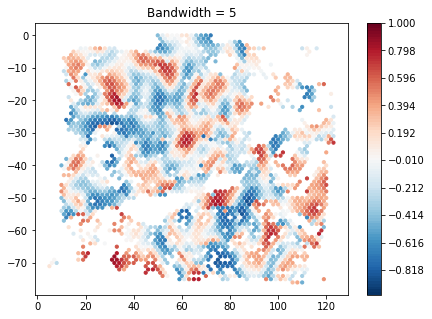

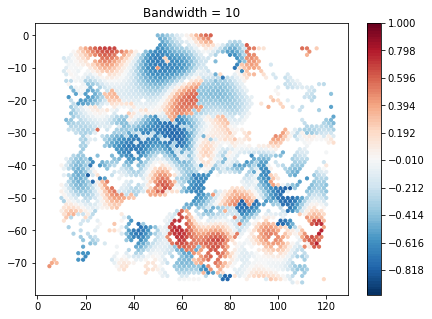

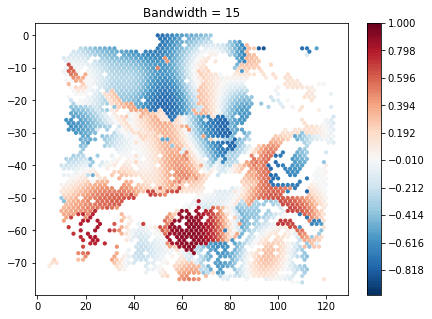

In [22]:
for sim_corrs, bandwidth in zip(sim_corrs_all, bandwidths):
    spatialcorr.plot.plot_slide(
        adata.obs,
        sim_corrs,
        vmin=-1,
        vmax=1,
        cmap='RdBu_r',
        colorbar=True,
        row_key='array_row',
        col_key='array_col',
        title=f'Bandwidth = {bandwidth}',
        dsize=10
    )
    plt.show()

## Generate data with region-specific correlation

We demonstrate how to simulate data in which the correlation is constant within each region, but may differ between regions.

First, we specify the correlation within each region:

In [11]:
CLUST_TO_CORR = {
    '0': 0.9,
    '1': 0.5,
    '2': 0.0,
    '3': -0.5,
    '4': -0.9
}

In [12]:
%%capture

sim_corrs, sim_covs, sim_adata = spatialcorr_sim.simulate_gene_pair_region_specific(
    adata.raw.to_adata(),        # The UMI counts data 
    CLUST_TO_CORR,               # Mapping each region/cluster to its latent correlation
    'COX6C',                     # The first gene to base the simulation on
    'COX6C',                     # The second gene to base the simulation on
    clust_key='leiden',          # The column in `adata.obs` that stores the region identifiers  
    row_key='array_row',         # The column in `adata.obs` that stores each spot's row coordinate
    col_key='array_col',         # The column in `adata.obs` that stores each spot's row coordinate
    poisson=True,                # Generate UMI counts using the Poisson-lognormal model
    size_factors=np.full((2, len(total_counts)), total_counts).T    # The size factors to use at each spot
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Now, like before, let's plot the latent correlation used to generate the counts at each spot versus the observed estimated correlation, where the estimation is performed using Guassian kernel estimation on the normalized UMI counts. We see they closely match.

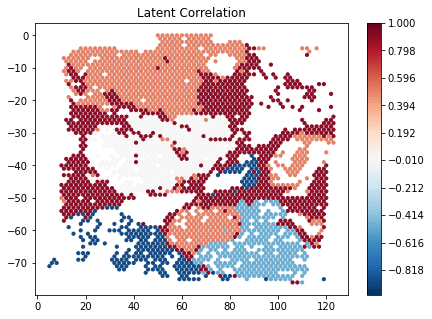

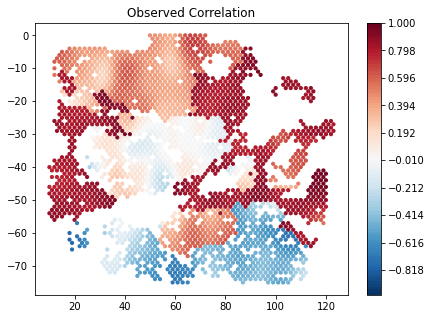

In [14]:
X_sim_norm = ndr.normalize(sim_adata.X, umi_counts=sim_adata.obs['n_counts'])

spatialcorr.plot.plot_slide(
    adata.obs,
    sim_corrs,
    vmin=-1,
    vmax=1,
    cmap='RdBu_r',
    colorbar=True,
    row_key='array_row',
    col_key='array_col',
    title='Latent Correlation',
    dsize=10
)

adata_sim_norm = AnnData(
    X=X_sim_norm,
    obs=sim_adata.obs,
    var=sim_adata.var
)
spatialcorr.plot.plot_correlation(
    adata_sim_norm, 
    '0', 
    '1',
    condition='leiden',
    title='Observed Correlation',
    row_key='array_row', 
    col_key='array_col'
); 

## Generate data for more than two genes at a time

In this section, we demonstrate how SpatialCorr-sim can be used to simulate spatially varying correlation across more than two genes at a time. Below, we illustrate an example of spatially varying correlation between four genes where the correlation matrix varies spatially, yet smoothly, within each region.

In [15]:
%%capture

# The genes we will use to base the simulation off of. 
# We will make all of the genes similar and matching COX6C 
# in the real data
GENES = [
    'COX6C', 
    'COX6C',
    'COX6C', 
    'COX6C' 
]

sim_corrs, sim_covs, sim_adata = spatialcorr_sim.simulate_gene_set_within_region_varying_correlation(
    adata.raw.to_adata(),        # The UMI counts data
    GENES,                       # The genes to base the simulation on
    clust_key='leiden',          # The column in `adata.obs` that stores the region identifiers
    bandwidth=10,                # Sets the coarseness of the varying correlation pattern.
    cov_strength=0.2,            # Sets how much the correlation varies across the slide.
    row_key='array_row',         # The column in `adata.obs` that stores each spot's row coordinate
    col_key='array_col',         # The column in `adata.obs` that stores each spot's row coordinate
    poisson=True,                # Generate UMI counts using the Poisson-lognormal model
    size_factors=np.full((len(GENES), len(total_counts)), total_counts).T    # The size factors to use at each spot
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Now we'll plot the latent correlation at each spot for every pair of genes in our simulated data

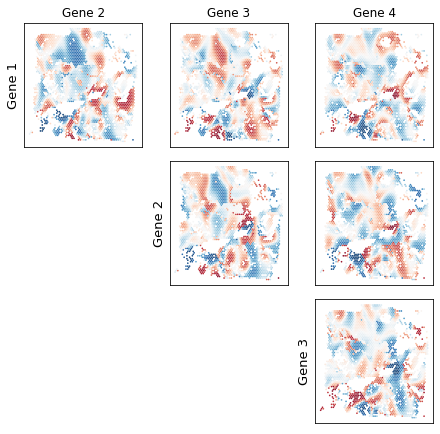

In [22]:
fig, axarr = plt.subplots(
    4,
    4,
    figsize=(8,8)
)
for row, ax_row in enumerate(axarr):
    for col, ax in enumerate(ax_row):
        corrs = [
            x[row][col]
            for x in sim_corrs
        ]
        if col > row:
            if row == 0:
                title = f'Gene {col+1}'
            else: 
                title = None
                
            if col == row+1:
                ax.set_ylabel(f'Gene {row+1}', fontsize=13)
            spatialcorr.plot.plot_slide(
                adata.obs,
                corrs,
                vmin=-1,
                vmax=1,
                cmap='RdBu_r',
                colorbar=False,
                ticks=False,
                row_key='array_row',
                col_key='array_col',
                dsize=0.4,
                title=title,
                ax=ax,
                figure=fig
            )
        else:
            ax.set_visible(False)
        
plt.tight_layout()
plt.show()